In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score

In [2]:
pd.set_option('display.max_columns', 60)
myData=pd.read_csv('imputedData.csv')
myData.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
#One hot encoding of categorical variables

#Create list with features to be dummified cols.
nonum_feats_names = ['Month','OperatingSystems','Browser','Region','VisitorType','Weekend']


dataModel = pd.concat([myData[['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
                               'TrafficType','SpecialDay']],
                       pd.get_dummies(myData[nonum_feats_names].astype('category')),myData['Revenue']],axis=1)
                      
dataModel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 57 columns):
Administrative                   12330 non-null int64
Administrative_Duration          12330 non-null float64
Informational                    12330 non-null int64
Informational_Duration           12330 non-null float64
ProductRelated                   12330 non-null int64
ProductRelated_Duration          12330 non-null float64
BounceRates                      12330 non-null float64
ExitRates                        12330 non-null float64
PageValues                       12330 non-null float64
TrafficType                      12330 non-null int64
SpecialDay                       12330 non-null float64
Month_Aug                        12330 non-null uint8
Month_Dec                        12330 non-null uint8
Month_Feb                        12330 non-null uint8
Month_Jul                        12330 non-null uint8
Month_June                       12330 non-null uint8
Month_Mar    

In [4]:
#Label Encoding of revenue

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
myData['Revenue'] = le.fit_transform(myData['Revenue'])
myData['Revenue'].value_counts()

myData['Revenue'].head()

# getting dependent and independent variables

x = dataModel
# removing the target column revenue from x
x = x.drop(['Revenue'], axis = 1)

y = myData['Revenue']

# checking the shapes
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (12330, 56)
Shape of y: (12330,)


In [5]:
# splitting the data

from sklearn.model_selection import train_test_split

x_baseTrain, x_baseTest, y_baseTrain, y_baseTest = train_test_split(x, y, test_size = 0.3, random_state = 42)

# checking the shapes

print("Shape of x_train :", x_baseTrain.shape)
print("Shape of y_train :", y_baseTrain.shape)
print("Shape of x_test :", x_baseTest.shape)
print("Shape of y_test :", y_baseTest.shape)

Shape of x_train : (8631, 56)
Shape of y_train : (8631,)
Shape of x_test : (3699, 56)
Shape of y_test : (3699,)


In [6]:
#SCALING WITH STANDARD Z SCORE SCALER
#Scaling the data first fitting it and transforming the training set
#to later apply the fit to transform the test set.
from sklearn.preprocessing import StandardScaler

num_cols_names = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
                               'TrafficType','SpecialDay']

#Instantiate Satandard Scaler
scaler = StandardScaler()
#Fit transform the numerical features in the training dataset to a new dataframe
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(x_baseTrain[num_cols_names]), 
                                     columns=num_cols_names, index= x_baseTrain.index)
#Integrate scaled values to the training set
for col in num_cols_names:
    x_baseTrain[col] = scaled_numfeats_train[col]
    
    
#Transform the numerical features inthe training dataset to a new dataframe
scaled_numfeats_test = pd.DataFrame(scaler.transform(x_baseTest[num_cols_names]),
                                    columns=num_cols_names, index= x_baseTest.index)
#Integrate scaled values to the test set
for col in num_cols_names:
    x_baseTest[col] = scaled_numfeats_test[col]

C:\Users\neera\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\neera\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit. applying this feature selection on corr fixed data

In [7]:
x_baseTrain.drop(labels=['Browser_1','BounceRates','ProductRelated','VisitorType_Returning_Visitor'], 
                 axis=1, inplace=True)
x_baseTest.drop(labels=['Browser_1','BounceRates','ProductRelated','VisitorType_Returning_Visitor'], 
                axis=1, inplace=True)

x_baseTrain.shape, x_baseTest.shape

C:\Users\neera\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((8631, 52), (3699, 52))

In [8]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(x_baseTrain, y_baseTrain)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(x_baseTest)[:, 1]
auc_score_all = roc_auc_score(y_baseTest, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.925058


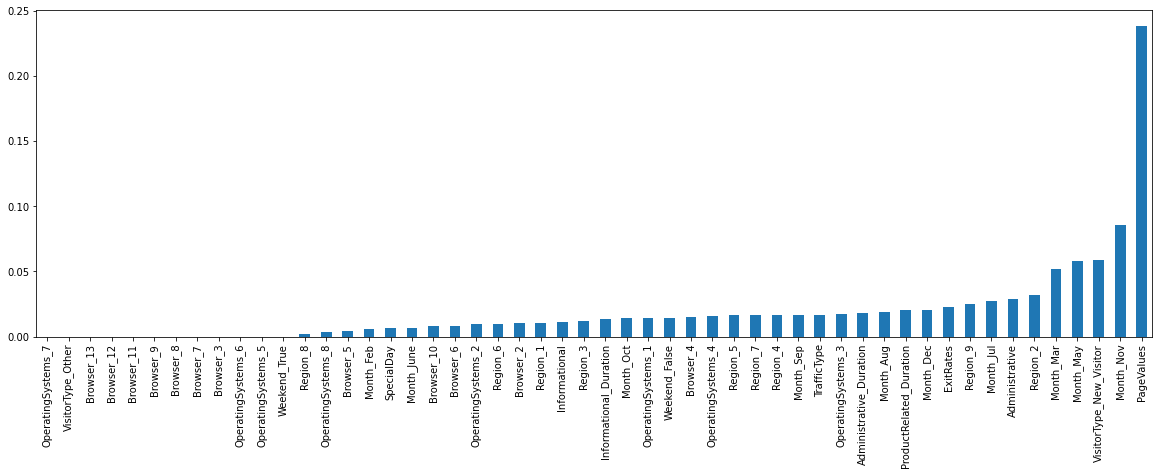

In [9]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = x_baseTrain.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [10]:
# view the list of ordered features
features = list(features.index)
features

['OperatingSystems_7',
 'VisitorType_Other',
 'Browser_13',
 'Browser_12',
 'Browser_11',
 'Browser_9',
 'Browser_8',
 'Browser_7',
 'Browser_3',
 'OperatingSystems_6',
 'OperatingSystems_5',
 'Weekend_True',
 'Region_8',
 'OperatingSystems_8',
 'Browser_5',
 'Month_Feb',
 'SpecialDay',
 'Month_June',
 'Browser_10',
 'Browser_6',
 'OperatingSystems_2',
 'Region_6',
 'Browser_2',
 'Region_1',
 'Informational',
 'Region_3',
 'Informational_Duration',
 'Month_Oct',
 'OperatingSystems_1',
 'Weekend_False',
 'Browser_4',
 'OperatingSystems_4',
 'Region_5',
 'Region_7',
 'Region_4',
 'Month_Sep',
 'TrafficType',
 'OperatingSystems_3',
 'Administrative_Duration',
 'Month_Aug',
 'ProductRelated_Duration',
 'Month_Dec',
 'ExitRates',
 'Region_9',
 'Month_Jul',
 'Administrative',
 'Region_2',
 'Month_Mar',
 'Month_May',
 'VisitorType_New_Visitor',
 'Month_Nov',
 'PageValues']

In [11]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        x_baseTrain.drop(features_to_remove + [feature], axis=1), y_baseTrain)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        x_baseTest.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_baseTest, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with all the features
    print('All features Test ROC AUC={}'.format((auc_score_all)))

    # determine the drop in the roc-auc
    diff_auc = auc_score_all - auc_score_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        auc_score_all = auc_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  OperatingSystems_7  which is feature  1  out of  52
New Test ROC AUC=0.9250576184379001
All features Test ROC AUC=0.9250576184379001
Drop in ROC AUC=0.0
remove:  OperatingSystems_7

testing feature:  VisitorType_Other  which is feature  2  out of  52
New Test ROC AUC=0.9250576184379001
All features Test ROC AUC=0.9250576184379001
Drop in ROC AUC=0.0
remove:  VisitorType_Other

testing feature:  Browser_13  which is feature  3  out of  52
New Test ROC AUC=0.9250576184379001
All features Test ROC AUC=0.9250576184379001
Drop in ROC AUC=0.0
remove:  Browser_13

testing feature:  Browser_12  which is feature  4  out of  52
New Test ROC AUC=0.9250576184379001
All features Test ROC AUC=0.9250576184379001
Drop in ROC AUC=0.0
remove:  Browser_12

testing feature:  Browser_11  which is feature  5  out of  52
New Test ROC AUC=0.9250576184379001
All features Test ROC AUC=0.9250576184379001
Drop in ROC AUC=0.0
remove:  Browser_11

testing featu

New Test ROC AUC=0.9269932639314145
All features Test ROC AUC=0.9274366753882982
Drop in ROC AUC=0.0004434114568837577
remove:  Month_Dec

testing feature:  ExitRates  which is feature  43  out of  52
New Test ROC AUC=0.9293174859433279
All features Test ROC AUC=0.9269932639314145
Drop in ROC AUC=-0.0023242220119134016
remove:  ExitRates

testing feature:  Region_9  which is feature  44  out of  52
New Test ROC AUC=0.9288629404887825
All features Test ROC AUC=0.9293174859433279
Drop in ROC AUC=0.0004545454545453742
remove:  Region_9

testing feature:  Month_Jul  which is feature  45  out of  52
New Test ROC AUC=0.9292003006179368
All features Test ROC AUC=0.9288629404887825
Drop in ROC AUC=-0.00033736012915430713
remove:  Month_Jul

testing feature:  Administrative  which is feature  46  out of  52
New Test ROC AUC=0.9299986082502922
All features Test ROC AUC=0.9292003006179368
Drop in ROC AUC=-0.0007983076323554439
remove:  Administrative

testing feature:  Region_2  which is feature 

In [35]:
# capture the 14 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=700, learning_rate=0.01)

# fit the model with the selected features
final_xgb.fit(x_baseTrain[features_to_keep], y_baseTrain)

# make predictions
y_pred_test = final_xgb.predict_proba(x_baseTest[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_baseTest, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))
#print('Test all features ROC AUC=%f' % (auc_score_all))

Test selected features ROC AUC=0.932670


As you can see, the xgb model built with 14 features shows a similar(in fact 1 point better) performance than the one built with the total features (0.93 vs 0.92).

We may not be able to get this right from the beginning though, as we did here. This method of feature selection does require that you try a few different tolerances / thresholds until you find the right number of features.

# Top features

In [36]:
features_to_keep

['Browser_6',
 'Region_6',
 'Browser_2',
 'Region_1',
 'Informational',
 'Month_Sep',
 'TrafficType',
 'Administrative_Duration',
 'ProductRelated_Duration',
 'Month_Mar',
 'Month_May',
 'VisitorType_New_Visitor',
 'Month_Nov',
 'PageValues']